In [3]:
import os
import glob
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from PIL import Image
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

/Users/baolinliu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Repo:
    
https://github.com/HiDhineshRaja/TensorFlow_Custom_ObjectDetection_

Original Code:

https://pythonprogramming.net/introduction-use-tensorflow-object-detection-api-tutorial/

In [4]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    # looks like it's doing a binary tree, going down the left and right branch
    # and finding text and appending all the variables in an array
    # then saves file into pandas
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[1].text),
                     int(root.find('size')[2].text),
                     member[1].text,
                     int(member[2][1].text),
                     int(member[2][3].text),
                     int(member[2][0].text),
                     int(member[2][2].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    image_path = os.path.join(os.getcwd(),'Stanford40/XMLAnnotations_short/')
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('Action_items.csv', index=None)
    print('Successfully converted xml to csv.')


main()

Successfully converted xml to csv.


In [50]:
full_labels = pd.read_csv('Action_items.csv')
full_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,climbing_275.jpg,600,800,climbing,302,150,537,596
1,running_008.jpg,400,450,running,122,18,223,281
2,shooting_an_arrow_102.jpg,300,400,shooting_an_arrow,154,92,315,300
3,shooting_an_arrow_116.jpg,400,534,shooting_an_arrow,103,116,472,400
4,climbing_261.jpg,400,534,climbing,186,2,327,352


In [51]:
grouped = full_labels.groupby('filename')

In [52]:
grouped.apply(lambda x: len(x)).value_counts()

1    1347
dtype: int64

In [53]:
gb = full_labels.groupby('filename')

In [54]:
grouped_list = [gb.get_group(x) for x in gb.groups]

In [55]:
n = len(grouped_list)

In [56]:
train_index = np.random.choice(len(grouped_list), size=int(.8*n), replace=False)
test_index = np.setdiff1d(list(range(n)), train_index)

In [57]:
len(train_index), len(test_index)

(1077, 270)

In [58]:
train = pd.concat([grouped_list[i] for i in train_index])
test = pd.concat([grouped_list[i] for i in test_index])

In [59]:
len(train), len(test)

(1077, 270)

In [60]:
train.to_csv('train_labels.csv', index=None)
test.to_csv('test_labels.csv', index=None)

In [61]:
# from collections import Counter
# test = pd.read_csv('test_labels.csv')
# Counter(test['class'])

In [62]:
# train = pd.read_csv('train_labels.csv')
# Counter(train['class'])

In [63]:
! python generate_tfrecord.py --csv_input=train_labels.csv  --output_path=train.record

/Users/baolinliu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Successfully created the TFRecords: /Users/baolinliu/Desktop/AssociatedPress_1/train.record


In [64]:
! python generate_tfrecord.py --csv_input=test_labels.csv  --output_path=test.record

/Users/baolinliu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Successfully created the TFRecords: /Users/baolinliu/Desktop/AssociatedPress_1/test.record


In [ ]:
# ! python models/research/model_main.py      --pipeline_config_path=modeling/faster_rcnn_resnet101_ava_v2.1.config      --model_dir=modeling/     --num_train_steps=100000     --num_eval_steps=10   --alsologtostderr

In [ ]:
# ! python train.py --logtostderr --pipeline_config_path=modeling/faster_rcnn_resnet101_coco.config --train_dir=modeling/ --label_map_path = modeling/data/label_map.pbtxt

In [ ]:
#! python train.py --logtostderr --pipeline_config_path=modeling/faster_rcnn_resnet101_coco.config --train_dir=modeling/model.ckpt-4620 --label_map_path = modeling/data/label_map.pbtxt

In [ ]:
# ! python models/research/export_inference_graph.py --input_type image_tensor --pipeline_config_path modeling_2/faster_rcnn_resnet101_ava_v2.1.config --trained_checkpoint_prefix=modeling_2/model.ckpt-50 --output_directory modeling_2/

In [158]:
! python export_inference_graph.py --input_type image_tensor --pipeline_config_path modeling/faster_rcnn_resnet101_coco.config --checkpoint_path modeling/model.ckpt-18938 --inference_graph_path modeling/inference_graph.pb

/Users/baolinliu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Instructions for updating:
keep_dims is deprecated, use keepdims instead
2018-10-29 09:41:49.446946: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [159]:
#! python train.py --logtostderr --pipeline_config_path=faster_rcnn_resnet101_full.config --train_dir=checkpoints/ --label_map_path=label_map.pbtxt


In [5]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.

PATH_TO_CKPT = 'modeling/inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'modeling/data/label_map_short.pbtxt'

In [6]:
NUM_CLASSES = 5

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [8]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [9]:
category_index

{1: {'id': 1, 'name': 'shooting_an_arrow'},
 2: {'id': 2, 'name': 'jumping'},
 3: {'id': 3, 'name': 'climbing'},
 4: {'id': 4, 'name': 'holding_an_umbrella'},
 5: {'id': 5, 'name': 'running'}}

In [10]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [11]:
# PATH_TO_TEST_IMAGES_DIR = 'Stanford40/JPEGImages'
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'ball{}.jpg'.format(i)) for i in range(1, 2) ]
TEST_IMAGE_PATHS = glob.glob('stanford40/test_images/*')
# Size, in inches, of the output images.
IMAGE_SIZE = (20, 10)

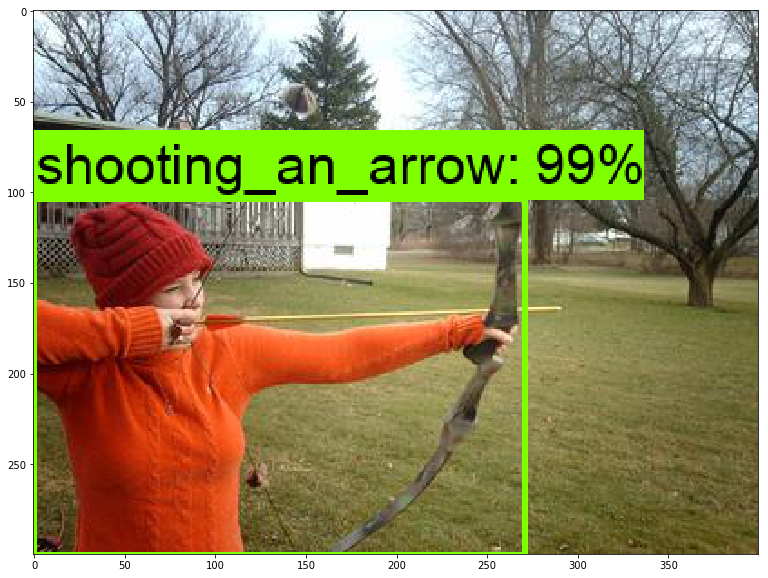

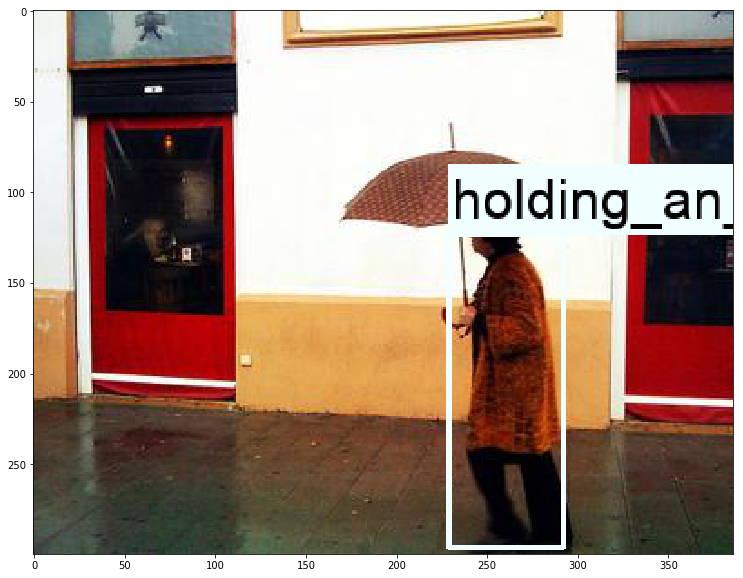

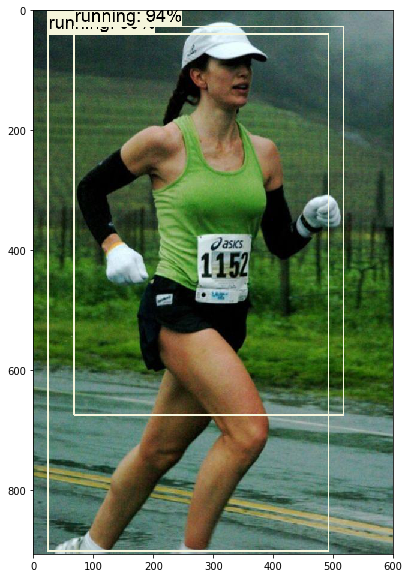

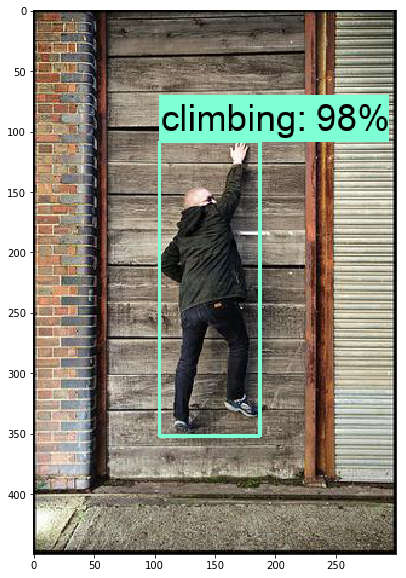

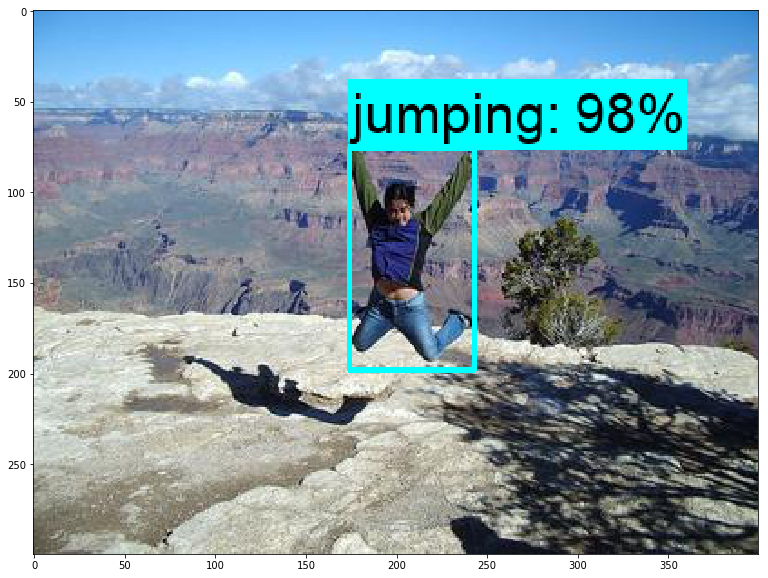

In [13]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # print(classes)  
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=3,
          min_score_thresh=.9)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
      # vis_util.save_image_array_as_png(image_np, 'boxed/boxed'+str(count))